**Estudiante:** Adriana Castillo

# El modelo epidémico de SIR
Una descripción matemática simple de la propagación de una enfermedad en una población es el llamado modelo SIR, que divide la población (fija) de N individuos en tres "compartimentos" que pueden variar en función del tiempo, t:

* S(t) son aquellos susceptibles pero aún no infectados con la enfermedad;
* I(t) es el número de individuos infecciosos;
* R(t) son aquellas personas que se han recuperado de la enfermedad y ahora tienen inmunidad.

El modelo SIR describe el cambio en la población de cada uno de estos compartimentos en términos de dos parámetros,  beta y  gamma.  
- Beta describe la tasa de contacto efectiva de la enfermedad: un individuo infectado entra en contacto con  beta*N otros individuos por unidad de tiempo (de los cuales la fracción que es susceptible a contraer la enfermedad es S/N).  
- Gamma es la tasa de recuperación promedio: es decir, 1/ gamma es el período de tiempo promedio durante el cual una persona infectada puede transmitirlo.

Las ecuaciones diferenciales que describen este modelo fueron derivadas primero por Kermack y McKendrick [ Proc. R. Soc. A , 115 , 772 (1927)]:

\begin{align*}
\frac{\mathrm{d}S}{\mathrm{d}t} &= -\frac{\beta S I}{N},\\
\frac{\mathrm{d}I}{\mathrm{d}t} &= \frac{\beta S I}{N} - \gamma I,\\
\frac{\mathrm{d}R}{\mathrm{d}t} &= \gamma I.
\end{align*}

El siguiente código de Python integra estas ecuaciones para una enfermedad caracterizada por los parámetros  beta=0.2, gamma=10  en una población de N=1000 (quizás 'gripe en una escuela ) El modelo se inicia con una sola persona infectada el día 0: I(0)=1. Las curvas trazadas de S(t), I(t) y R(t) están diseñadas para verse un poco mejor que los valores predeterminados de Matplotlib.

## Generar la prediccion del modelos SIR

 Se debe  estimar el valor de 
- β 
- γ

Para ajustar el modelo SIR con los casos confirmados reales (el número de personas infecciosas) del Ecuador.
 
 Para ello deben seguir el siguiente tutorial 
 https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html
 


S0: 6800 	I0: 7603 	R0: 597

Ecuador, beta=0.39999922, gamma=0.45000000, R0:0.88888716


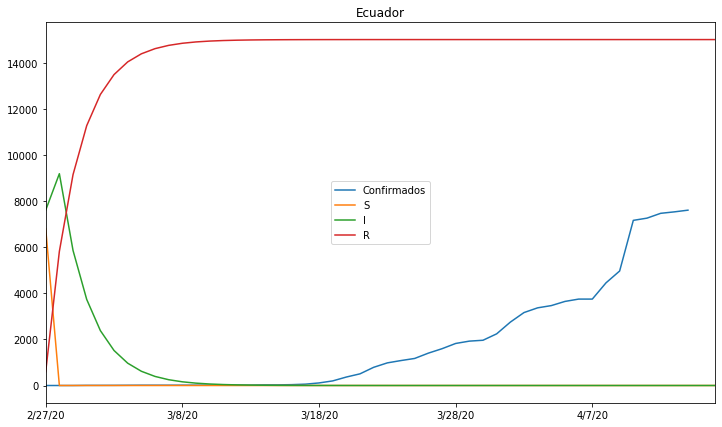

In [4]:
# 1. Implementar solo teniendo en cuenta los casos confirmados
import numpy as np
import pandas as pd
from csv import reader
from csv import writer
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import argparse
import sys
import json
import ssl
import urllib.request

class Learner(object):
    def __init__(self, country, loss, start_date, predict_range,s_0, i_0, r_0):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0
        self.Beta = 0
        self.Gamma = 0

    def load_confirmed(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data, country, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        return new_index, extended_actual, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))
    
    def train(self):
        data = (self.load_confirmed(self.country))
        self.i0=data[-1]
        optimal = minimize(loss, [0.001, 0.001], args=(data, self.s_0, self.i_0, self.r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.45)])
        beta, gamma = optimal.x
        self.Beta, self.Gamma = optimal.x
        new_index, extended_actual, prediction = self.predict(beta, gamma, data, self.country, self.s_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Confirmados': extended_actual, 'S': prediction.y[0], 'I': prediction.y[1], 'R': prediction.y[2]}, index=new_index)
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.set_title(self.country)
        df.plot(ax=ax)
        print(f"\n{self.country}, beta={beta:.8f}, gamma={gamma:.8f}, R0:{(beta/gamma):.8f}")
        
casos = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
casos  = casos [casos ['Country/Region'] == 'Ecuador'].iloc[0].loc[:]

def loss(point, data, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))

poblacion=15000
i0=casos [-1]
r0=597
s0=poblacion - i0 - r0
print('S0:',s0,'\tI0:',i0,'\tR0:',r0)
learner = Learner('Ecuador', loss, '2/27/20', 50, s0, i0, r0)
learner.train()


Ecuador, beta=0.00001598, gamma=0.01124009, R0:0.00142150


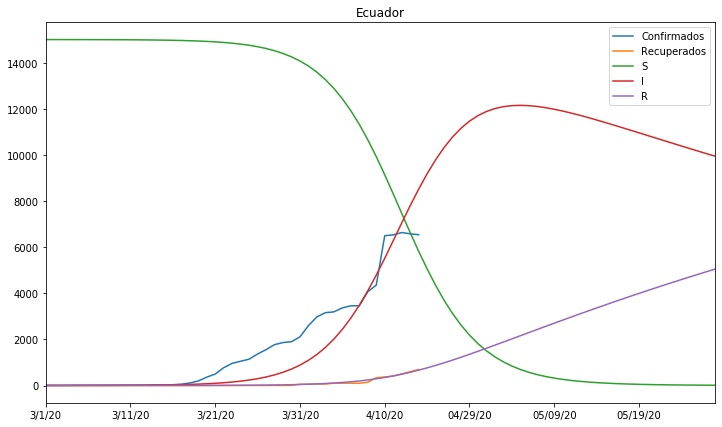

In [2]:
# 2. Implementar teniendo en cuenta los casos confirmados y recuperados.
import numpy as np
import pandas as pd
from csv import reader
from csv import writer
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import argparse
import sys
import json
import ssl
import urllib.request

class Learner(object):
    def __init__(self, country, loss, start_date, predict_range,s_0, i_0, r_0):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0
        self.Beta = 0
        self.Gamma = 0

    def load_confirmed(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_recovered(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]

    def load_dead(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]
    
    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        current = current + timedelta(days=9)
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data, recovered, death, country, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return new_index, extended_actual, extended_recovered, extended_death, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))


    def train(self):
        recovered = self.load_recovered(self.country)
        death = self.load_dead(self.country)
        data = (self.load_confirmed(self.country) - recovered - death)
        
        optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, self.s_0, self.i_0, self.r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data, recovered, death, self.country, self.s_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Confirmados': extended_actual, 'Recuperados': extended_recovered, 'S': prediction.y[0], 'I': prediction.y[1], 'R': prediction.y[2]}, index=new_index)
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.set_title(self.country)
        df.plot(ax=ax)
        print(f"\n{self.country}, beta={beta:.8f}, gamma={gamma:.8f}, R0:{(beta/gamma):.8f}")

dfC = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
dfC = dfC[dfC['Country/Region'] == 'Ecuador'].iloc[0].loc[:]
def loss(point, data, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))


def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2
poblacion=15000
i0=1
r0=0
s0=poblacion  - i0 - r0

learner = Learner('Ecuador', loss, '3/1/20', 80, s0, i0, r0)
learner.train()


## Calculos de incidencia

Para obtener metricas de incidencia se debe calcular la tasa de prevalencia, incidencia y la relacion, para esto leer y obtener estos datos con la ultima lectura.

https://www.paho.org/hq/index.php?option=com_content&view=article&id=14402:indicadores-de-salud-aspectos-conceptuales-y-operativos-seccion-2&catid=9894&limitstart=2&Itemid=101&lang=es

In [5]:
# Implementar

url='https://covid.ourworldindata.org/data/ecdc/total_cases.csv'
df = pd.read_csv(url)
df = df.replace(np.nan, 0)

df = df.loc[:,['date','Ecuador']]
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2019-12-31", FMT)).days)
df.loc[:,[60,'Ecuador']]
tiempo=df.index[-1]-df.index[59]+1

def incidencia(nuevos,riesgo,n):
    return (nuevos/riesgo)*pow(10,n)

def prevalencia(casos,poblacion,n):
    return (casos/poblacion)*pow(10,n)

def relacion(incidencia,tiempo):
    return incidencia*tiempo

inci=incidencia((dfC[-1]-dfC[-2]),(17080000-dfC[-1]),5)
prev=prevalencia(dfC[-1],17080000,5)
rela=relacion(inci,tiempo)

print('Tasa de Incidencia: ',inci,' cada 100.000 personas')
print('Tasa de Prevalencia: ',prev,' cada 100.000 personas')
print('Relación: ',rela)

Tasa de Incidencia:  0.4334482146824491  cada 100.000 personas
Tasa de Prevalencia:  44.514051522248245  cada 100.000 personas
Relación:  20.37206609007511


## Analisis
El modelo SIR es uno de los modelos epidemiológicos más simples que puede capturar muchas características típicas de un brote epidémico. El nombre del modelo proviene de las iniciales S (población susceptible), I (población infectada) y R (población recuperada). El modelo vincula los cambios entre las tres poblaciones (susceptibilidad, infección y recuperación) a través de la tasa de infección y el período promedio de infección.

## Conclusiones
Al no contar con los datos reales de los casos confirmados, recuperados y de fallecidos el modelo no será preciso, será un aproximado el valor de beta, gamma, este modelo predicirá el rango de infectaos, la tasa de recuperados e infectados es muy baja al no contar con datos reales.

## Opinion
A pesar de las medidas tomadas en el país, se puede apreciar que la tasa de contagiados sigue aumentando y el numero de recuperados crece lentamente, de igual forma la tasa de fallecidos es muy alta lo cual es algo muy procupante. Esto debe recalcalse a todos los ciudadanos paraque tomen conciencia y se cuiden tanto a ellos mismos como a las demás personas del país.

# Referencias:
- https://www.agenciasinc.es/Reportajes/Un-modelo-un-teorema-y-teoria-de-juegos-contra-el-coronavirus
- https://rpubs.com/dsfernandez/422937
- https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2